In [1]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from matplotlib import pyplot as plt

import copy
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

# print(type(foreground_classes))

In [4]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):   #5000*batch_size = 50000 data points
    images, labels = dataiter.next()
    for j in range(batch_size):
        if(classes[labels[j]] in background_classes):
            img = images[j].tolist()
            background_data.append(img)
            background_label.append(labels[j])
        else:
            img = images[j].tolist()
            foreground_data.append(img)
            foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img#.numpy()
    plt.imshow(np.transpose(npimg, axes = (1, 2, 0)))
    plt.show()

In [6]:
# img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
# imshow(img1)
# img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
# imshow(img2)
# img3 = torch.cat((img1,img2),2)
# imshow(img3)
# print(img2.size())

In [7]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
    """
      bg_idx : list of indexes of background_data[] to be used as background images in mosaic
      fg_idx : index of image to be used as foreground image from foreground data
      fg : at what position/index foreground image has to be stored out of 0-8
    """
    image_list=[]
    j=0
    for i in range(9):
        if i != fg:
            image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
            j+=1
        else: 
            image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
            label = foreground_label[fg_idx]  #-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
    #image_list = np.concatenate(image_list ,axis=0)
    image_list = torch.stack(image_list) 
    return image_list,label

In [8]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    mosaic_list_of_images.append(image_list)
    mosaic_label.append(label)

5


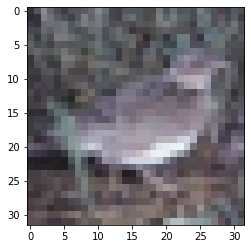

bird


In [9]:
qw=10010

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [10]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""

    def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
        """
          Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list_of_images
        self.label = mosaic_label
        self.fore_idx = fore_idx

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [11]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, z):
        x = torch.zeros([batch,9],dtype=torch.float64)
        y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
        x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):
            x[:,i] = self.helper(z[:,i])[:,0]
        x = F.softmax(x,dim=1)   # alphas
    
        x1 = x[:,0]
        torch.mul(x1[:,None,None,None],z[:,0])

        for i in range(9):            
            x1 = x[:,i]          
            y = y + torch.mul(x1[:,None,None,None],z[:,i])
        return y , x 
  
    def helper(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,3)

    def forward(self,y):  #z batch of list of 9 images
        y1 = self.pool(F.relu(self.conv1(y)))
        y1 = self.pool(F.relu(self.conv2(y1)))
        y1 = y1.view(-1, 16 * 5 * 5)

        y1 = F.relu(self.fc1(y1))
        y1 = F.relu(self.fc2(y1))
        y1 = F.relu(self.fc3(y1))
        y1 = self.fc4(y1)
        return y1

In [13]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [14]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [15]:
where = Wherenet().double()
where = where.to(device)
# out_where,alphas = where(input1)
# out_where.shape,alphas.shape

In [16]:
what = Whatnet().double()
what =what.to(device)

In [17]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

cifar_train_acc = []
cifar_test_acc  =  []


col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 150

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
ig = np.random.randint(0,250)
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0
    c = 0
    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients
        
        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        
        # display plots 
#         if(c==0): 
#             disp_plot(inputs[ig,:],avg_inp[ig,:],ig,labels[ig].item(),predicted[ig].item(), alphas[ig,:], fore_idx[ig].item())
#             c+=1
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 40 == 39:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 40))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            full_batch_train_true = 0
            full_batch_test_true = 0 
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0
            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in trainloader:
                inputs,labels = data
                
                inputs,labels = inputs.to(device), labels.to(device)
                
                outputs = what(inputs.double())
                
                _,predicted = torch.max(outputs.data,1)
                #print(predicted.cpu().numpy(),"labels",labels.cpu().numpy())
                full_batch_train_true+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
            
            cifar_train_acc.append(full_batch_train_true)
            print("focibly_true_train_accuracy: ",full_batch_train_true)
            for data in testloader:
                inputs,labels = data
                
                inputs,labels = inputs.to(device), labels.to(device)
                
                outputs = what(inputs.double())
                
                _,predicted = torch.max(outputs.data,1)
                #print(predicted.cpu().numpy(),"labels",labels.cpu().numpy())
                full_batch_test_true+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
            
            cifar_test_acc.append(full_batch_test_true)
            print("focibly_true_test_accuracy: ",full_batch_test_true)
                
            
            
            
            for data in test_loader:
                inputs, labels , fore_idx = data
                inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        torch.save(where.state_dict(),"weights_forcibly_true/where_model_epoch"+str(epoch)+".pt")
        torch.save(what.state_dict(),"weights_forcibly_true/what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where.state_dict(),"weights_forcibly_true/where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what.state_dict(),"weights_forcibly_true/what_model_epoch"+str(epoch)+".pt")

[1,    40] loss: 1.102
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.099
[3,    40] loss: 1.099
[3,    80] loss: 1.099
[3,   120] loss: 1.099
[4,    40] loss: 1.099
[4,    80] loss: 1.099
[4,   120] loss: 1.099
[5,    40] loss: 1.099
[5,    80] loss: 1.099
[5,   120] loss: 1.099
focibly_true_train_accuracy:  5000
focibly_true_test_accuracy:  1000
[6,    40] loss: 1.099
[6,    80] loss: 1.098
[6,   120] loss: 1.098
[7,    40] loss: 1.098
[7,    80] loss: 1.098
[7,   120] loss: 1.098
[8,    40] loss: 1.098
[8,    80] loss: 1.098
[8,   120] loss: 1.098
[9,    40] loss: 1.098
[9,    80] loss: 1.098
[9,   120] loss: 1.098
[10,    40] loss: 1.097
[10,    80] loss: 1.097
[10,   120] loss: 1.097
focibly_true_train_accuracy:  6460
focibly_true_test_accuracy:  1312
[11,    40] loss: 1.096
[11,    80] loss: 1.095
[11,   120] loss: 1.095
[12,    40] loss: 1.093
[12,    80] loss: 1.092
[12,   120] loss: 1.090
[13,    40] loss: 1.089
[

[97,    40] loss: 0.067
[97,    80] loss: 0.078
[97,   120] loss: 0.093
[98,    40] loss: 0.083
[98,    80] loss: 0.077
[98,   120] loss: 0.080
[99,    40] loss: 0.101
[99,    80] loss: 0.077
[99,   120] loss: 0.085
[100,    40] loss: 0.073
[100,    80] loss: 0.061
[100,   120] loss: 0.058
focibly_true_train_accuracy:  12691
focibly_true_test_accuracy:  2382
[101,    40] loss: 0.054
[101,    80] loss: 0.051
[101,   120] loss: 0.068
[102,    40] loss: 0.042
[102,    80] loss: 0.047
[102,   120] loss: 0.048
[103,    40] loss: 0.055
[103,    80] loss: 0.061
[103,   120] loss: 0.077
[104,    40] loss: 0.051
[104,    80] loss: 0.057
[104,   120] loss: 0.060
[105,    40] loss: 0.054
[105,    80] loss: 0.061
[105,   120] loss: 0.061
focibly_true_train_accuracy:  12612
focibly_true_test_accuracy:  2355
[106,    40] loss: 0.057
[106,    80] loss: 0.059
[106,   120] loss: 0.078
[107,    40] loss: 0.061
[107,    80] loss: 0.051
[107,   120] loss: 0.060
[108,    40] loss: 0.045
[108,    80] loss: 

In [18]:
full_train_acc = 0 
for data in train_loader:
    inputs,labels,fore_idx = data
    inputs,labels,fore_idx = inputs.to(device), labels.to(device),fore_idx.to(device)
    avg_inp,alphas = where(inputs)
    outputs = what(avg_inp)
    _,predicted = torch.max(outputs.data,1)
    #print(predicted.cpu().numpy(),"labels",labels.cpu().numpy())
    full_train_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
print("mosaic_data_training_accuracy :",full_train_acc/30000)

mosaic_data_training_accuracy : 0.9943666666666666


In [19]:
full_test_acc = 0 
for data in test_loader:
    inputs,labels,fore_idx = data
    inputs,labels,fore_idx = inputs.to(device), labels.to(device),fore_idx.to(device)
    avg_inp,alphas = where(inputs)
    outputs = what(avg_inp)
    _,predicted = torch.max(outputs.data,1)
    #print(predicted.cpu().numpy(),"labels",labels.cpu().numpy())
    full_test_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
print("mosaic_data_test_accuracy :",full_test_acc/10000)

mosaic_data_test_accuracy : 0.8617


In [21]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7
df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [22]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,30000,905,9125,1871,18099
1,9,0,30000,988,10093,1910,17009
2,14,0,30000,2931,8959,3262,14848
3,19,8,29992,4092,9350,3157,13401
4,24,5752,24248,7553,8250,3440,10757
5,29,13021,16979,11232,7341,3225,8202
6,34,15362,14638,13886,7090,2781,6243
7,39,17732,12268,16424,6682,2224,4670
8,44,19113,10887,18208,6486,1663,3643
9,49,20081,9919,19337,6441,1294,2928


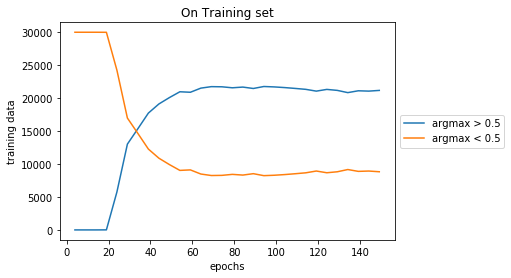

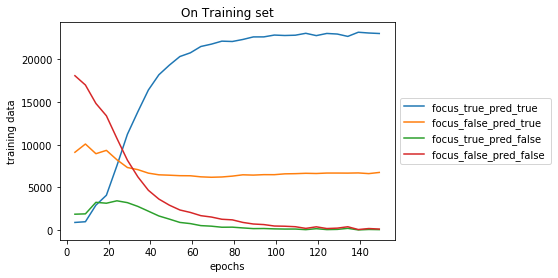

In [23]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [24]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,10000,297,3059,605,6039
1,9,0,10000,341,3417,607,5635
2,14,0,10000,965,3240,1109,4686
3,19,44,9956,1460,3096,995,4449
4,24,1901,8099,2617,2789,1277,3317
5,29,4581,5419,3866,2420,1137,2577
6,34,5217,4783,4669,2227,976,2128
7,39,6482,3518,5174,2071,844,1911
8,44,6075,3925,5559,2130,888,1423
9,49,7028,2972,6058,1934,601,1407


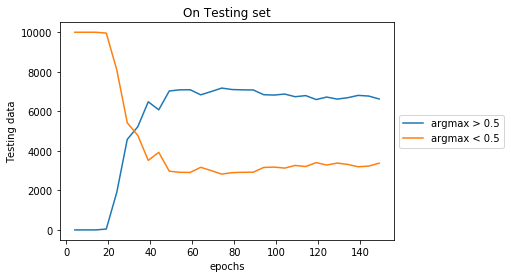

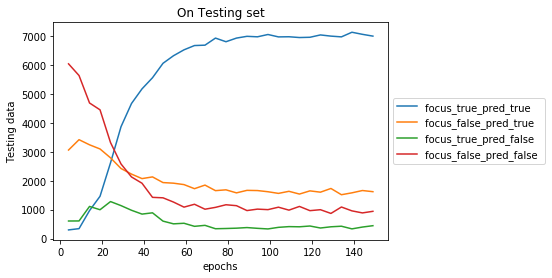

In [25]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

Text(0.5, 1.0, 'forcibly true train accuracy')

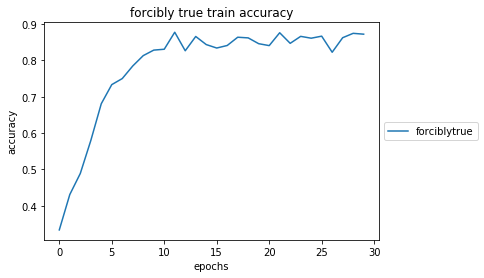

In [26]:
plt.plot(np.array(cifar_train_acc)/15000,label= "forciblytrue")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("forcibly true train accuracy")

Text(0.5, 1.0, 'forcibly true test accuracy')

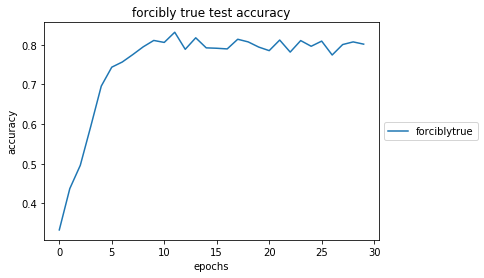

In [27]:
plt.plot(np.array(cifar_test_acc)/3000,label= "forciblytrue")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("forcibly true test accuracy")